In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

Cleaning del dataset predictive_maintenance

In [2]:
# === PARAMETRI VARIABILI DAL DATASET===
TIME_INTERVAL = 15  # Intervallo temporale tra le righe (valore numerico)
TIME_UNIT = "min"  # Unità di tempo ('min', 'h', 's', ecc.)

# === 1. Caricamento del dataset ===
df = pd.read_csv("./data/raw/predictive_maintenance.csv")

# === 2. Creazione della colonna 'date' ===
df['date'] = pd.Timestamp("2024-01-01 00:00:00")  # Data iniziale arbitraria
df['date'] = df['date'] + pd.to_timedelta(df.index * TIME_INTERVAL, unit=TIME_UNIT)

# === 3. Rimozione delle colonne inutili ===
df.drop(columns=['UDI', 'Product ID','Target','Failure Type'], inplace=True)

# === 4. Dichiarazione delle feature numeriche ===
numerical_features = ['Air temperature [K]', 'Process temperature [K]', 
                      'Rotational speed [rpm]', 'Torque [Nm]', 
                      'Tool wear [min]']

# === 5. Nome del file cleaned ===
filename = "predictive_maintenance.csv"

# === 6. Encoding delle variabili categoriche ===
# Convertiamo 'Type' (L, M, H) in numerico
type_encoder = LabelEncoder()
df['Type'] = type_encoder.fit_transform(df['Type'])  # L -> 0, M -> 1, H -> 2

In [3]:
# === 7. Normalizzazione delle feature numeriche ===
#scaler = StandardScaler()
#df[numerical_features] = scaler.fit_transform(df[numerical_features])

# === 8. Salvataggio del nuovo dataset ===
df.to_csv(f"./data/final/cleaned_{filename}", index=False)
print(f"✅ Dataset trasformato e salvato come {filename}")

✅ Dataset trasformato e salvato come predictive_maintenance.csv


Procediamo  avalidare il dataset per verificare se è possibile sfruttarlo per l'informer e individuare una o più variabili target

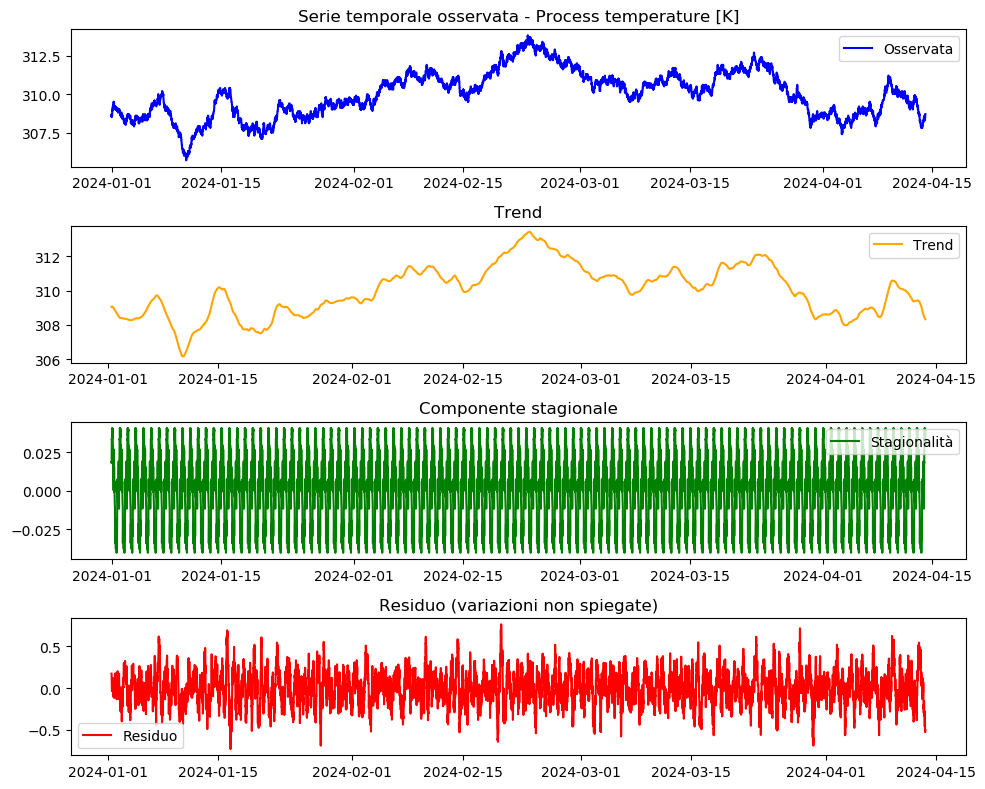

✅ Analisi stagionale completata per 'Process temperature [K]'. Controlla i grafici per identificare la stagionalità!


In [8]:
def analyze_seasonality(file_path, time_column, target_column, freq='15min', period=None):
    """
    Analizza la stagionalità di una variabile temporale in un dataset.

    :param file_path: Percorso del file CSV
    :param time_column: Nome della colonna contenente le date/tempi
    :param target_column: Nome della variabile da analizzare
    :param freq: Frequenza dei dati (es. '15min', 'H', 'D' per minuti, ore, giorni)
    :param period: Periodo della stagionalità (se None, verrà stimato)
    """

    # === 1. Caricare il dataset ===
    df = pd.read_csv(file_path, parse_dates=[time_column])  # Converte la colonna data in formato datetime
    df.set_index(time_column, inplace=True)  # Imposta la colonna temporale come indice

    # === 2. Stimare il periodo se non fornito ===
    if period is None:
        # Se la frequenza è ogni 15 minuti, assumiamo una stagionalità giornaliera (24h = 96 punti)
        if freq == '15min':
            period = 96
        elif freq == 'H':  # Frequenza oraria → Stagionalità settimanale (24h * 7 giorni)
            period = 24 * 7
        elif freq == 'D':  # Frequenza giornaliera → Stagionalità annuale (365 giorni)
            period = 365
        else:
            raise ValueError("Specifica un periodo corretto per l'analisi stagionale!")

    # === 3. Eseguire la decomposizione della serie temporale ===
    result = seasonal_decompose(df[target_column], model='additive', period=period)

    # === 4. Generare i grafici ===
    plt.figure(figsize=(10, 8))

    # Osservata
    plt.subplot(4, 1, 1)
    plt.plot(result.observed, label='Osservata', color='blue')
    plt.title(f'Serie temporale osservata - {target_column}')
    plt.legend()

    # Trend
    plt.subplot(4, 1, 2)
    plt.plot(result.trend, label='Trend', color='orange')
    plt.title('Trend')
    plt.legend()

    # Stagionalità
    plt.subplot(4, 1, 3)
    plt.plot(result.seasonal, label='Stagionalità', color='green')
    plt.title('Componente stagionale')
    plt.legend()

    # Residuo
    plt.subplot(4, 1, 4)
    plt.plot(result.resid, label='Residuo', color='red')
    plt.title('Residuo (variazioni non spiegate)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"✅ Analisi stagionale completata per '{target_column}'. Controlla i grafici per identificare la stagionalità!")

# === ESEMPIO DI UTILIZZO ===
# Percorso del file CSV
file_path = f"./data/final/cleaned_{filename}"  # Sostituisci con il tuo dataset

# Nome della colonna temporale e della variabile da analizzare
time_column = "date"
target_column = "Process temperature [K]"  # Sostituisci con la variabile da analizzare

# Analizzare la stagionalità
analyze_seasonality(file_path, time_column, target_column, freq='15min')

🔍 1️⃣ Serie Temporale Osservata (Primo Grafico)
📌 Cosa ho cercato?
Variazioni regolari e ripetitive nel tempo.
Fluttuazioni che sembrano seguire un ciclo costante.
🔎 Cosa ho notato?
✅ Ci sono oscillazioni ripetute nel tempo, ma c’è anche una tendenza a lungo termine che sale e poi scende.

🔍 2️⃣ Trend (Secondo Grafico)
📌 Cosa ho cercato?
Movimento a lungo termine: Se il trend sale o scende, può indicare una direzione generale nei dati.
Se la serie ha solo un trend e nessun ciclo chiaro, probabilmente non è stagionale.
🔎 Cosa ho notato?
✅ Il trend cresce gradualmente fino a metà febbraio e poi scende lentamente.
✅ Questo significa che c’è un andamento generale, ma non spiega tutte le variazioni della serie.

🔍 3️⃣ Componente Stagionale (Terzo Grafico)
📌 Cosa ho cercato?
Oscillazioni regolari e ripetute → Se ci sono, allora c’è stagionalità chiara.
Ampiezza costante nel tempo → Se i picchi sono sempre simili, la stagione è stabile.
🔎 Cosa ho notato?
✅ Ci sono cicli regolari con ampiezza simile per tutto il periodo.
✅ I picchi sembrano ripetersi ogni giorno → Indica stagionalità giornaliera.
💡 Conclusione: Qui ho capito che c’è una stagionalità chiara perché il ciclo si ripete con intervalli costanti.

🔍 4️⃣ Residuo (Quarto Grafico)
📌 Cosa ho cercato?
Se il residuo è molto rumoroso e caotico, significa che la serie ha molte variazioni imprevedibili.
Se il residuo ha ancora pattern visibili, allora la stagionalità non è stata catturata completamente.
🔎 Cosa ho notato?
✅ Il residuo ha molto rumore, ma non mostra pattern ciclici evidenti.
✅ Questo significa che la stagionalità è stata catturata bene nella componente stagionale.

📌 Conclusione Finale
✔ Sì, c’è stagionalità in "Process temperature [K]" perché il grafico della componente stagionale mostra pattern chiari e regolari.
✔ Il ciclo sembra giornaliero, poiché le oscillazioni si ripetono in modo costante.
✔ Il modello può sfruttare questa stagionalità per fare previsioni più accurate.
🚀 Vuoi che analizziamo un altro caso o che verifichiamo se il modello sta sfruttando bene questa informazione? 😊


📊 **Analisi della stagionalità per ciascuna variabile:**

❌ Type: Nessuna stagionalità rilevante (ACF Peaks: [0], FFT Peaks: [0.])
❌ Air temperature [K]: Nessuna stagionalità rilevante (ACF Peaks: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96], FFT Peaks: [0.])
❌ Process temperature [K]: Nessuna stagionalità rilevante (ACF Peaks: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96], FFT Peaks: [0.])
❌ Rotational speed [rpm]: Nessuna stagionalità rilevante (ACF Peaks: [0], FFT Peaks: [0.])
❌ Torque [N

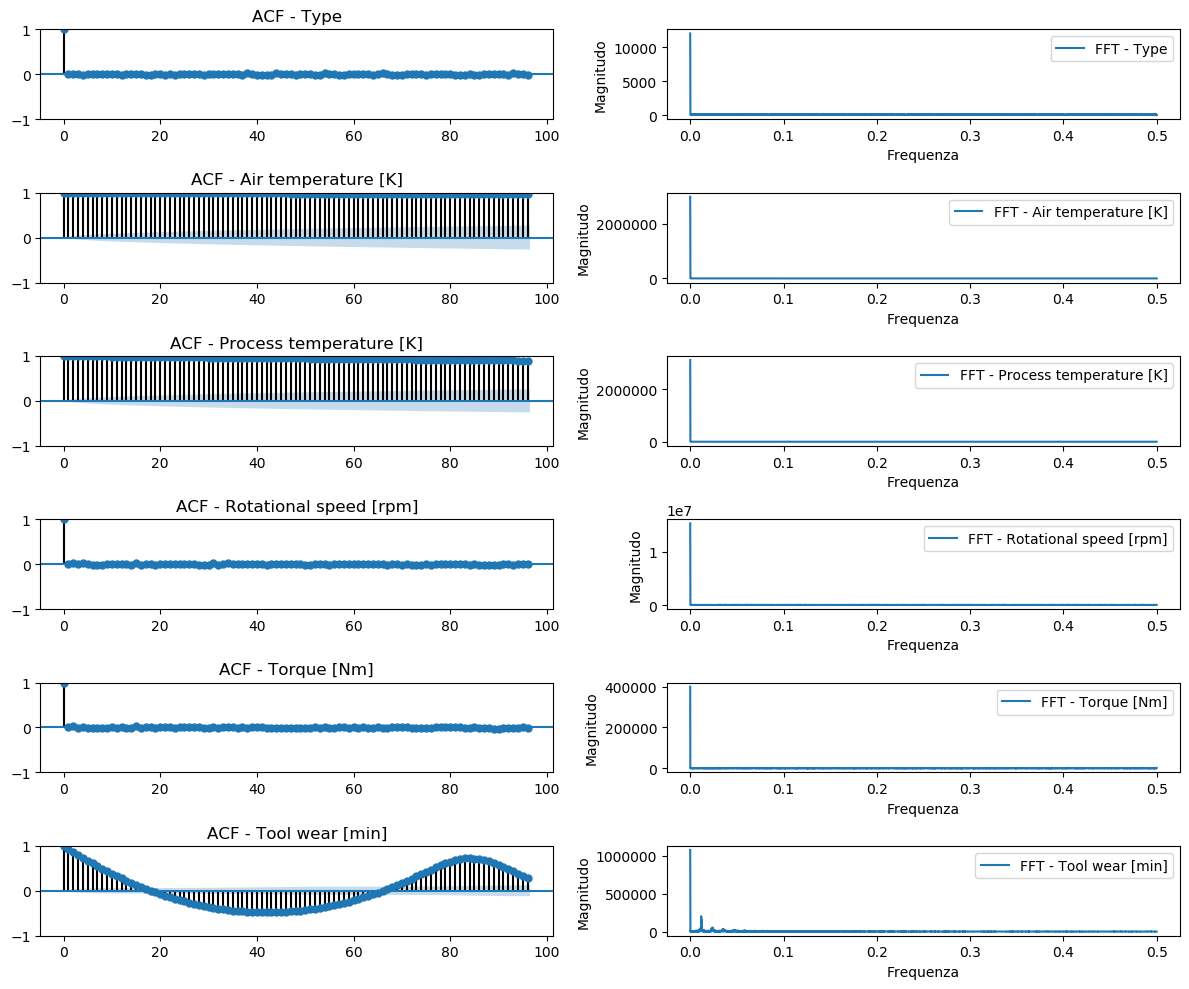


🌟 **Variabili con stagionalità rilevata:**
🔹 Tool wear [min]


In [12]:
def detect_seasonality_auto(df, lags=96, freq_threshold=0.05):
    """
    Analizza automaticamente la stagionalità di tutte le variabili numeriche
    usando ACF (Autocorrelation Function) e FFT (Fourier Transform).

    :param df: DataFrame Pandas con indice temporale
    :param lags: Numero di lag da analizzare nell'ACF (default 96 = 24h con dati ogni 15 min)
    :param freq_threshold: Soglia per identificare picchi nella FFT (default 0.05)
    """

    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("L'indice del DataFrame deve essere di tipo DatetimeIndex.")

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    seasonal_vars = []

    plt.figure(figsize=(12, 10))

    print("\n📊 **Analisi della stagionalità per ciascuna variabile:**\n")

    for i, col in enumerate(numeric_cols, 1):
        # === 1️⃣ Autocorrelation Function (ACF) ===
        ax = plt.subplot(len(numeric_cols), 2, 2*i-1)
        sm.graphics.tsa.plot_acf(df[col].dropna(), lags=lags, ax=ax, title=f"ACF - {col}")

        # Identificare picchi nella ACF
        acf_values = sm.tsa.acf(df[col].dropna(), nlags=lags)
        acf_peaks = np.where(acf_values > 0.3)[0]  # Consideriamo picchi sopra 0.3

        # === 2️⃣ Fourier Transform (FFT) ===
        ax2 = plt.subplot(len(numeric_cols), 2, 2*i)
        fft_result = np.fft.fft(df[col].dropna())
        freqs = np.fft.fftfreq(len(fft_result))
        positive_freqs = freqs[:len(freqs) // 2]
        positive_magnitude = np.abs(fft_result[:len(freqs) // 2])
        ax2.plot(positive_freqs, positive_magnitude, label=f"FFT - {col}")
        ax2.set_xlabel("Frequenza")
        ax2.set_ylabel("Magnitudo")
        ax2.legend()

        # Identificare picchi nella FFT
        freq_peaks = positive_freqs[np.where(positive_magnitude > freq_threshold * max(positive_magnitude))]

        # === 3️⃣ Valutazione della stagionalità ===
        if len(acf_peaks) > 1 and len(freq_peaks) > 1:
            seasonal_vars.append(col)
            print(f"✅ {col}: Stagionalità identificata! (ACF Peaks: {acf_peaks}, FFT Peaks: {freq_peaks})")
        else:
            print(f"❌ {col}: Nessuna stagionalità rilevante (ACF Peaks: {acf_peaks}, FFT Peaks: {freq_peaks})")

    plt.tight_layout()
    plt.show()

    # Stampa il risultato finale
    if seasonal_vars:
        print("\n🌟 **Variabili con stagionalità rilevata:**")
        for var in seasonal_vars:
            print(f"🔹 {var}")
    else:
        print("❌ Nessuna variabile con stagionalità rilevante trovata.")

    return seasonal_vars

# **ESEMPIO DI UTILIZZO**
# Il DataFrame `df` deve avere la colonna temporale come indice
df.index = pd.to_datetime(df.index)
seasonal_variables = detect_seasonality_auto(df, lags=96, freq_threshold=0.05)

Script necessario per convertire un dataset .h5 in un csv

In [13]:
import h5py

with h5py.File('./data/raw/METR-LA.h5', 'r') as file:
    # Stampa tutte le chiavi di primo livello
    print("Chiavi nel file:", list(file.keys()))
    
    # Se vuoi esplorare ulteriormente la struttura:
    def print_name(name):
        print(name)
        
    file.visit(print_name)

# Leggi il DataFrame dal file HDF5 specificando la chiave 'df'
df = pd.read_hdf('./data/raw/METR-LA.h5', key='df')

# Salva il DataFrame in formato CSV
df.to_csv('./data/final/METR-LA.csv', index=False)
print("Conversione completata! Il file CSV è stato salvato come 'METR-LA.csv'.")


Chiavi nel file: ['df']
df
df/axis0
df/axis1
df/block0_items
df/block0_values
